<a href="https://colab.research.google.com/github/babymlin/Imbalanced/blob/main/anomaly_detection_defect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob
import cv2
import matplotlib.pyplot as  plt
import numpy as np
import os
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models, losses, callbacks, preprocessing

In [ ]:
# Download dataset from GoogleDrive
# https://drive.google.com/file/d/1kIef9G5Og7VgDPEHt_vIJMTKHdC7_0Kq
!gdown --id 1kIef9G5Og7VgDPEHt_vIJMTKHdC7_0Kq --output "./NEU_defect.zip"
!unzip -q "./NEU_defect.zip"

Downloading...
From: https://drive.google.com/uc?id=1kIef9G5Og7VgDPEHt_vIJMTKHdC7_0Kq
To: /content/NEU_defect.zip
56.8MB [00:02, 23.0MB/s]


In [ ]:
IMG_SIZE = 256
class_names = ['PS', 'Sc', 'RS', 'In', 'Cr', 'Pa']
class_map = {name: i for i, name in enumerate(class_names)}

normal_paths = glob('NEU_defect/PS_*.bmp')

In [ ]:
len(normal_paths)

300

In [ ]:
def read_imgs(paths):
    x = np.zeros((len(paths), IMG_SIZE, IMG_SIZE, 1))
    for i, path in enumerate(tqdm(paths)):
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.
        x[i] = img[:, :, :1] # gray scale
    y = x.copy() # same as input imgs
    return x, y        

In [ ]:
x_train, y_train = read_imgs(normal_paths)

In [ ]:
# normal imgs
len(x_train)

300

In [ ]:
def conv_bn(x, filters, bn=True, strides=1):
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=strides)(x)
    if bn:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

init_filter = 16
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
# Encoder
l = conv_bn(input_layer, init_filter, strides=2)
l = conv_bn(l, init_filter*2, strides=2)
l = conv_bn(l, init_filter*4, strides=2)
l = conv_bn(l, init_filter*8, strides=2)

# Decoder
l = layers.Conv2DTranspose(filters=init_filter*8, kernel_size=3, strides=2, padding='same', activation='relu')(l)
l = layers.Conv2DTranspose(filters=init_filter*4, kernel_size=3, strides=2, padding='same', activation='relu')(l)
l = layers.Conv2DTranspose(filters=init_filter*2, kernel_size=3, strides=2, padding='same', activation='relu')(l)
l = layers.Conv2DTranspose(filters=init_filter, kernel_size=3, strides=2, padding='same', activation='relu')(l)
output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)                                                         
model = models.Model(input_layer, output_layer)

In [ ]:
model.compile(loss=losses.mean_squared_error, optimizer=keras.optimizers.Adam())

In [ ]:
# Data augmentation
data_gen = preprocessing.image.ImageDataGenerator(horizontal_flip=True, 
                                                  vertical_flip=True).flow(x_train, y_train, batch_size=32)

model.fit(data_gen, 
          epochs=20, 
          callbacks=[callbacks.ReduceLROnPlateau(patience=3)],
          validation_data=(x_train, y_train)
         )

Epoch 1/20
10/10 [==============================] - 34s 168ms/step - loss: 0.0718 - val_loss: 0.0639
Epoch 2/20
10/10 [==============================] - 1s 102ms/step - loss: 0.0322 - val_loss: 0.0487
Epoch 3/20
10/10 [==============================] - 1s 100ms/step - loss: 0.0334 - val_loss: 0.0221
Epoch 4/20
10/10 [==============================] - 1s 100ms/step - loss: 0.0279 - val_loss: 0.0176
Epoch 5/20
10/10 [==============================] - 1s 98ms/step - loss: 0.0270 - val_loss: 0.0348
Epoch 6/20
10/10 [==============================] - 1s 101ms/step - loss: 0.0262 - val_loss: 0.0368
Epoch 7/20
10/10 [==============================] - 1s 102ms/step - loss: 0.0269 - val_loss: 0.0499
Epoch 8/20
10/10 [==============================] - 1s 100ms/step - loss: 0.0245 - val_loss: 0.0461
Epoch 9/20
10/10 [==============================] - 1s 98ms/step - loss: 0.0237 - val_loss: 0.0425
Epoch 10/20
10/10 [==============================] - 1s 101ms/step - loss: 0.0240 - val_loss: 0.0413


In [ ]:
loss_max = 1e-1

0.03583451275501794


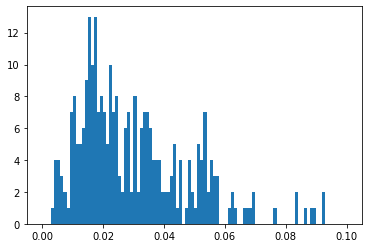

In [ ]:
# Reconstruction error for training data
y_pred = model.predict(x_train)
loss = np.mean(np.square(y_pred - y_train), axis=(1,2))
plt.hist(loss, bins=100, range=(0, loss_max))
print(np.mean(loss))


ROC AUC score:  0.49994999999999995


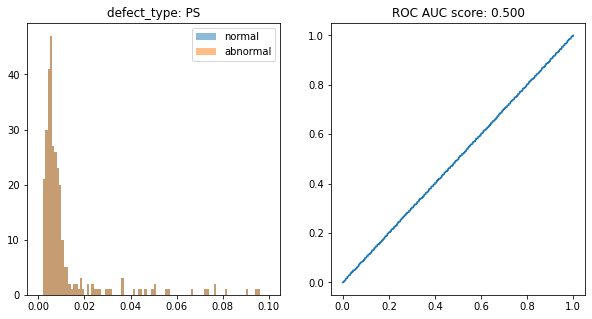


ROC AUC score:  0.8022


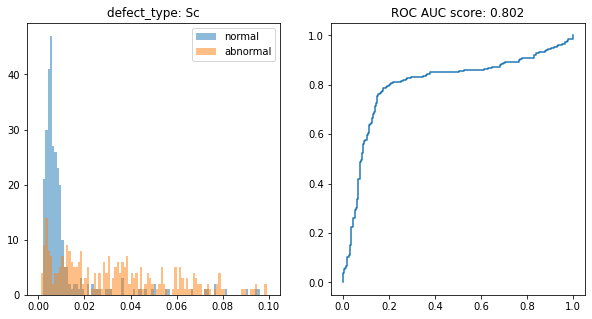


ROC AUC score:  0.46055555555555555


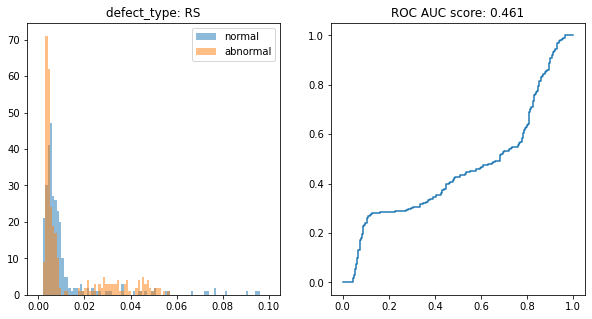


ROC AUC score:  0.7029777777777778


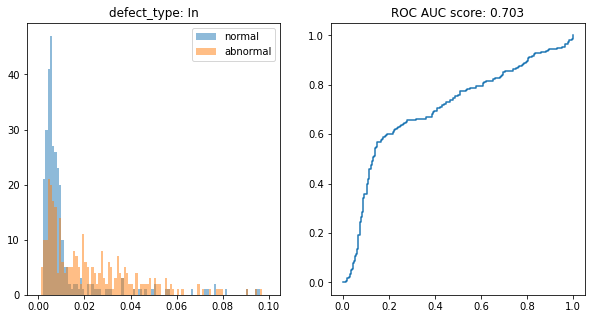


ROC AUC score:  0.6953555555555555


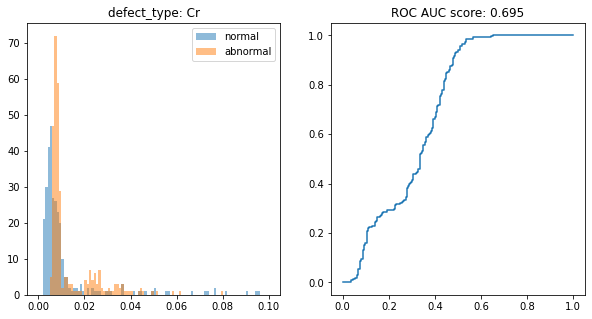


ROC AUC score:  0.9141222222222222


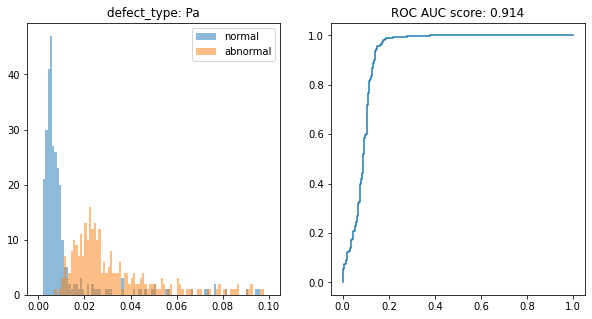

In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report

for defect_type in ['PS', 'Sc', 'RS', 'In', 'Cr', 'Pa']:
    abnormal_paths = glob(f'NEU_defect/{defect_type}_*.bmp')
    x_abnormal, y_abnormal = read_imgs(abnormal_paths)
    y_abnormal_pred = model.predict(x_abnormal)
    loss_abnormal = np.mean(np.square(y_abnormal_pred - y_abnormal), axis=(1,2)) # reconstruction error for abnormal data
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(loss, bins=100, range=(0, loss_max), alpha=0.5)
    plt.hist(loss_abnormal, bins=100, range=(0, loss_max), alpha=0.5)
    plt.legend(['normal', 'abnormal'])
    plt.title(f'defect_type: {defect_type}')

    y_normal = np.zeros(shape=(len(x_train)))
    y_abnormal = np.ones(shape=(len(x_abnormal)))
    y_true = np.concatenate((y_normal, y_abnormal))
    y_pred = np.concatenate((loss, loss_abnormal))

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    print('ROC AUC score: ', roc_auc)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr)
    plt.title(f'ROC AUC score: {roc_auc:.3f}')
    plt.show()
    print('========= \n')